In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns; sns.set_theme()
from sklearn import tree
import graphviz
from dtreeviz.trees import dtreeviz

## Reading Data and Preprocessing

In [38]:
df = pd.read_csv('covid_train.csv')
#df = df.dropna()
train_length = len(df)
df_test = pd.read_csv('covid_tests.csv')
test_length = len(df_test)
#df = pd.concat([df,df_test],axis=0)

In [39]:
for i in set(df.loc[:,"Reporting_PHU_City"]):
    lat = set(df[df.loc[:,"Reporting_PHU_City"]==i].loc[:,"Reporting_PHU_Latitude"])
    lon = set(df[df.loc[:,"Reporting_PHU_City"]==i].loc[:,"Reporting_PHU_Longitude"])
    print(i,"\t",lat,lon)
print("No of sets ",len(set(df.loc[:,"Reporting_PHU_City"])))

St. Thomas 	 {42.77780366} {-81.15115646}
Kingston 	 {44.2278735} {-76.5252108}
Brantford 	 {43.151811} {-80.27437415}
Owen Sound 	 {44.57619612} {-80.94097993}
Whitby 	 {43.898604999999996} {-78.940341}
Brockville 	 {44.61584261} {-75.70283308}
Toronto 	 {43.65659125} {-79.37935801}
Simcoe 	 {42.84782526} {-80.30381491}
Thunder Bay 	 {48.4005716} {-89.25885079999998}
Hamilton 	 {43.2576311} {-79.87134089}
Waterloo 	 {43.46287573} {-80.52091315}
Point Edward 	 {42.98641646} {-82.40480836}
Sault Ste. Marie 	 {46.5323728} {-84.3148358}
Oakville 	 {43.41399692} {-79.74479581}
Thorold 	 {43.1165366} {-79.2412197}
New Liskeard 	 {47.5092835} {-79.681632}
North Bay 	 {46.31320706} {-79.46784050000002}
Newmarket 	 {44.048023} {-79.480239}
Barrie 	 {44.41071258} {-79.68630597}
Stratford 	 {43.3686615} {-81.00191283}
Belleville 	 {44.18667362} {-77.39144554}
Mississauga 	 {43.6474713} {-79.7088933}
Guelph 	 {43.5248813} {-80.2337433}
Ottawa 	 {45.3456651} {-75.7639122}
Windsor 	 {42.3087965} {-

### From the above, it is clear that every city corresponds to a unique set of co-ordinates. This clears up the fact that no city has two different Public Health Units reporting covid results. Also, city and co-ordinates convey the same information, so we can choose to use one over the other to avoid data redundancy. For convenience we'll go with City information and drop co-ordinates.

In [40]:
df.describe(include='all')

,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1
count,14845,14851,14851,14851,5831,14851.000000,14851.000000,14851
unique,9,4,6,34,1,NaN,NaN,3
top,80s,FEMALE,OB,Toronto,Yes,NaN,NaN,Fatal
freq,2212,7499,5389,5158,5831,NaN,NaN,4951
mean,NaN,NaN,NaN,NaN,NaN,43.741457,-79.565291,NaN
std,NaN,NaN,NaN,NaN,NaN,0.752952,1.589850,NaN
min,NaN,NaN,NaN,NaN,NaN,42.308796,-94.488254,NaN
25%,NaN,NaN,NaN,NaN,NaN,43.647471,-79.708893,NaN
50%,NaN,NaN,NaN,NaN,NaN,43.656591,-79.379358,NaN
75%,NaN,NaN,NaN,NaN,NaN,43.656591,-79.379358,NaN


In [7]:
def find_mode(df):
    AG = pd.unique(df.Age_Group)
    mode = np.zeros((9,1))
    for i in list(df.loc[:,"Age_Group"].values):
        if str(i)!='nan':
            i = int(i)
            mode[i-1]+=1
    m = np.argmax(mode)
    return m

In [8]:
df['Age_Group'] = df['Age_Group'].replace('<20',1).replace('20s',2).replace('30s',3).replace('40s',4).replace('50s',5).replace('60s',6).replace('70s',7).replace('80s',8).replace('90s',9)
df_oc_fatal = df[df["Outcome1"]=="Fatal"]
df_oc_res = df[df["Outcome1"]=="Resolved"]
df_oc_nres = df[df["Outcome1"]=="Not Resolved"]
print("'Fatal' age Mode ",find_mode(df_oc_fatal))
print("'Resolved' age Mode ",find_mode(df_oc_res))
print("'Not Resolved' age Mode ",find_mode(df_oc_nres))
df_oc_fatal["Age_Group"]=df_oc_fatal["Age_Group"].replace(np.nan,7)
df_oc_res["Age_Group"]=df_oc_res["Age_Group"].replace(np.nan,1)
df_oc_nres["Age_Group"]=df_oc_nres["Age_Group"].replace(np.nan,1)
df = pd.concat([df_oc_fatal,df_oc_res,df_oc_nres])

'Fatal' age Mode  7
'Resolved' age Mode  1
'Not Resolved' age Mode  1


### Here, we are filling in the missing values with the mode of 'Age_Group' obtained class wise. Filling it with the global mode seems counter intuitive in this case since age is one of the most critical features and filling it with global mode could potentially impact the data integrity of the model. We can also afford to do this because, as per our analysis in feature selection process, there is no imbalance or skew in the Outcome class. Meaning there are almost equal number of samples for all 3 outcomes. Alternatively, we can choose to drop the missing values all together.

In [9]:
df.describe(include='all')

,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1
count,14851.000000,14851,14851,14851,5831,14851.000000,14851.000000,14851
unique,NaN,4,6,34,1,NaN,NaN,3
top,NaN,FEMALE,OB,Toronto,Yes,NaN,NaN,Fatal
freq,NaN,7499,5389,5158,5831,NaN,NaN,4951
mean,5.168608,NaN,NaN,NaN,NaN,43.741457,-79.565291,NaN
std,2.615903,NaN,NaN,NaN,NaN,0.752952,1.589850,NaN
min,1.000000,NaN,NaN,NaN,NaN,42.308796,-94.488254,NaN
25%,3.000000,NaN,NaN,NaN,NaN,43.647471,-79.708893,NaN
50%,5.000000,NaN,NaN,NaN,NaN,43.656591,-79.379358,NaN
75%,8.000000,NaN,NaN,NaN,NaN,43.656591,-79.379358,NaN


In [41]:
df['Age_Group'] = df['Age_Group'].replace('<20',1).replace('20s',2).replace('30s',3).replace('40s',4).replace('50s',5).replace('60s',6).replace('70s',7).replace('80s',8).replace('90s',9)
df['Outcome1']=df['Outcome1'].replace('Resolved',1).replace('Fatal',-1).replace('Not Resolved',0)
df['Outbreak_Related'] = df['Outbreak_Related'].replace('Yes',1).replace(np.nan,0)
df['Client_Gender'] = df['Client_Gender'].replace('UNSPECIFIED',np.nan)
#df['Case_AcquisitionInfo']=df['Case_AcquisitionInfo'].replace('NO KNOWN EPI LINK','OTHERWISE').replace('UNSPECIFIED EPI LINK','OTHERWISE')
df = df.dropna()

# Feature analysis

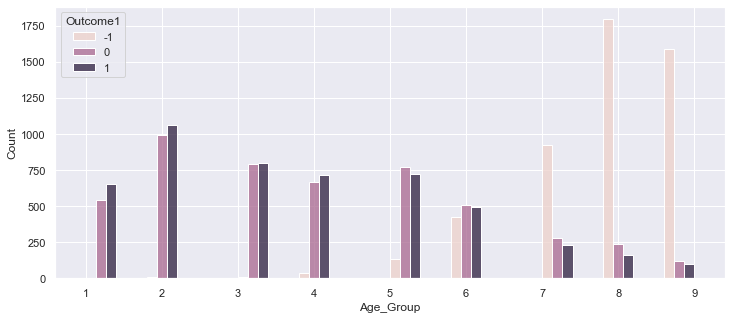

In [11]:
fig1 = plt.figure(figsize=(12,5))
sns.histplot(data=df, x="Age_Group", hue = "Outcome1", multiple='dodge')

### Age seems to be a crucial feature looking at this histogram. The above graph reflects the medical community's claim that covid is dangerous to older population.

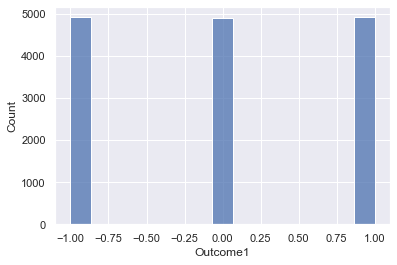

In [12]:
sns.histplot(data=df, x='Outcome1')

### Outcome1 seems to be balanced. There is no skew towards one particular outcome class which is a good thing.

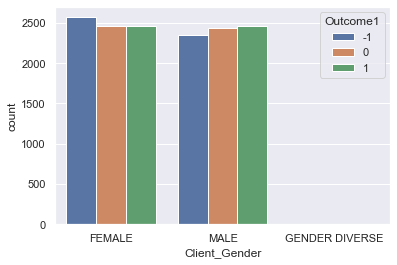

In [13]:
sns.countplot(data = df,x="Client_Gender", hue="Outcome1")

### GENDER DIVERSE seems to be a serious outlier with no more than a couple of values. We can explore removing this. There does not seem to be any sort of imbalance with regards to outcome by gender. Outcome seems to be balanced across gender. On the contrary this could be specific to the dataset and not true in general. We should investigate further before concluding on the significance of this feature.

## GENDER VS AGE VS INFECTION
### This comparison seems logical

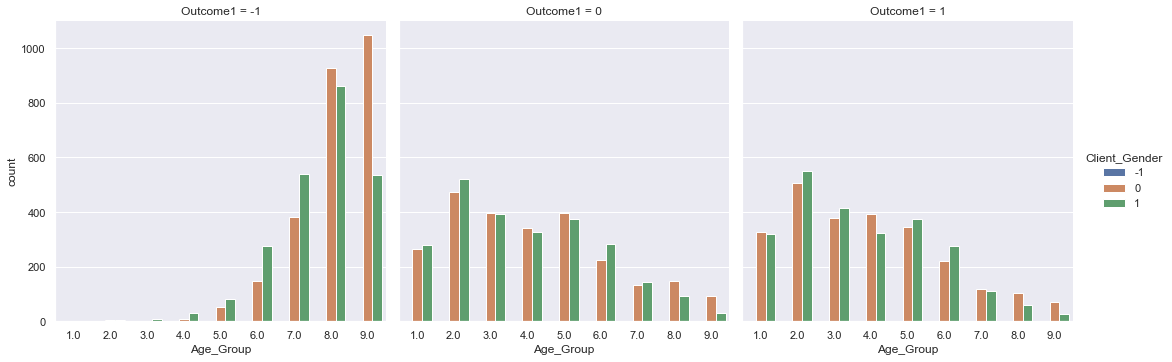

In [14]:
x = list(df.columns)
cols_needed = ["Age_Group","Client_Gender","Outcome1"]
for col in cols_needed:
    x.remove(col)
df_tailor = df.drop(columns=x)
df_tailor['Client_Gender'] = df_tailor['Client_Gender'].replace("MALE",1).replace("FEMALE",0).replace("GENDER DIVERSE",-1)
sns.catplot(data = df_tailor, x = "Age_Group", hue = 'Client_Gender',col ="Outcome1", kind="count")

### There seems to be a decrease in fatalities among very old men which is kind of counter intuitive from what medical community claims. Data can be deceiving so lets examine for class imbalance.

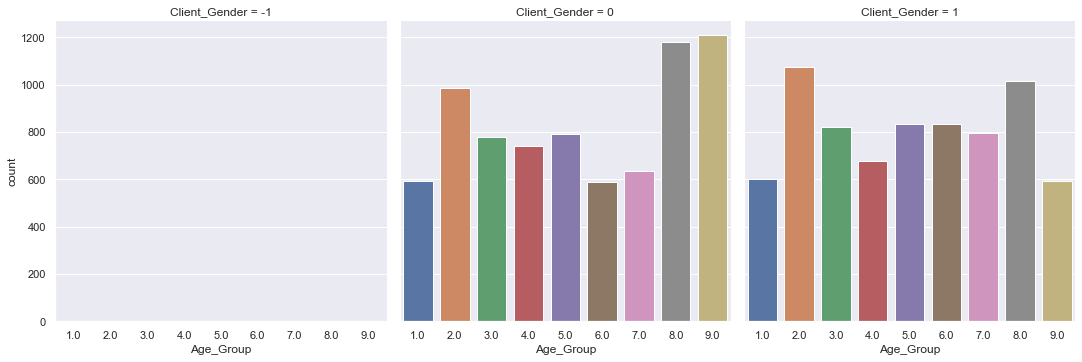

In [15]:
sns.catplot(data = df_tailor, x = "Age_Group", col = 'Client_Gender', kind="count")

### As suspected, there seems to be class imbalance. There are very less very old men in our count. Now we can confidently say that "Client_Gender" feature is not of much use to our analysis. It does not seem to provide any useful information to deduce outcome.

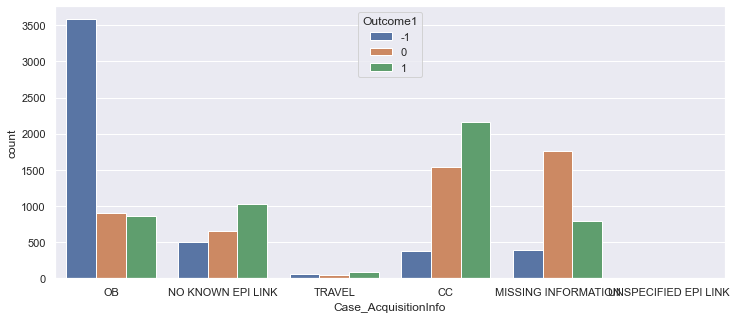

In [16]:
fig1 = plt.figure(figsize=(12,5))
sns.countplot(data= df, x = "Case_AcquisitionInfo", hue = "Outcome1")

### OB, CC and MISSING INFORMATION seem to be contain useful information as each one peaks at a different outcome. Distribution of NO KNOWN EPI LINK, TRAVEL and UNSPECIFIED EPI LINK seem to be similar so we'll try combining them.

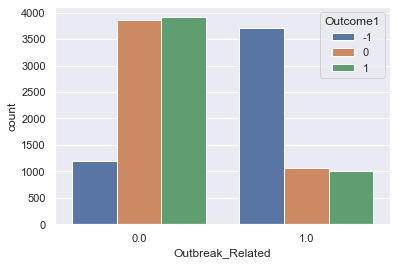

In [17]:
sns.countplot(data= df, x = "Outbreak_Related", hue = "Outcome1")

### This feature is definitely useful to differentiate Fatalities from the rest but between the other two, its not so much useful. Perhaps it can vary with age.

In [36]:
Heal = ["Mississauga","Newmarket","Waterloo","Cornwall","Simcoe","Brantford","Peterborough","Owen Sound","Belleville","Kingston","Kenora","Pembroke","North Bay","New Liskeard","Oakville", "Point Edward"]
Int = ["Ottawa","Whitby","Windsor","St. Thomas","Brockville"]
Major = ["Toronto","Thorold","Hamilton","London","Barrie","Guelph","Thunderbay","Port Hope","Stratford","Chatham","Sudbury","Timmins","Sault Ste. Marie"]
l = len(Heal)+len(Int)+len(Major)
l

34

### An attempt was made to group cities into three categories based on the proportion of outcome they have. This method did not give a positive improvement in terms of performance. 

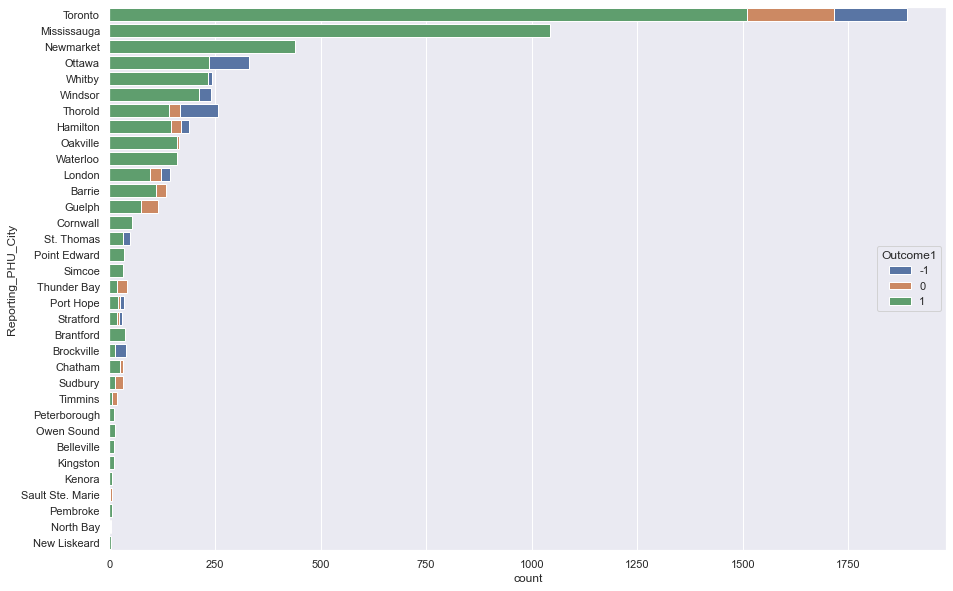

In [18]:
fig1 = plt.figure(figsize = (15,10))
sns.countplot(data= df, y = "Reporting_PHU_City", hue="Outcome1",dodge=False, order = df['Reporting_PHU_City'].value_counts().index)

### Only few Cities have clear distinction. We can keep only those and combine the rest into a single category.
We'll keep [Toronto, Mississauga, Newmarket, Ottawa, Whitby, Windsor, Thorold, Hamilton, Oakville, Waterloo, London, Barrie, Guelph, Cornwall, St. Thomas, Thunder Bay, Brockville] and group the rest as 'Otherwise'. This helps us reduce the number of features we end up with.

In [93]:
df_tailor = df.copy()
i=1
for city in list(df["Reporting_PHU_City"].unique()):
    df_tailor["Reporting_PHU_City"] = df_tailor["Reporting_PHU_City"].replace(city,i)
    print(city,"\t",i)
    i+=1

Oakville 	 1
Guelph 	 2
Barrie 	 3
Toronto 	 4
Ottawa 	 5
Newmarket 	 6
Thorold 	 7
Whitby 	 8
Windsor 	 9
Waterloo 	 10
Mississauga 	 11
New Liskeard 	 12
Simcoe 	 13
Hamilton 	 14
Thunder Bay 	 15
London 	 16
Point Edward 	 17
St. Thomas 	 18
Kingston 	 19
Cornwall 	 20
Port Hope 	 21
North Bay 	 22
Stratford 	 23
Owen Sound 	 24
Brantford 	 25
Chatham 	 26
Brockville 	 27
Timmins 	 28
Kenora 	 29
Sudbury 	 30
Belleville 	 31
Peterborough 	 32
Sault Ste. Marie 	 33
Pembroke 	 34


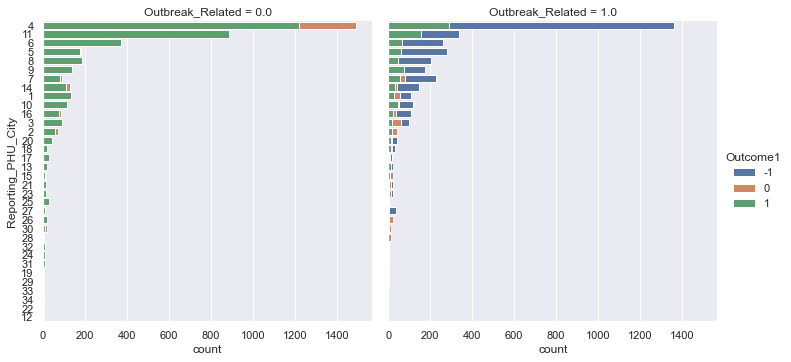

In [97]:
sns.catplot(data = df_tailor, y = "Reporting_PHU_City", hue = 'Outcome1',col ="Outbreak_Related", kind="count",dodge=False, order = df_tailor['Reporting_PHU_City'].value_counts().index)

### Outbreak feature seems to pair well with City so we'll keep both of them in our analysis.

# Applying Preprocessing and inferences from Feature Selection Activity

### Following are a list of preprocessing functions to be applied during testing.

In [42]:
def step1(df,train = True):    
    df['Age_Group'] = df['Age_Group'].replace('<20',1).replace('20s',2).replace('30s',3).replace('40s',4).replace('50s',5).replace('60s',6).replace('70s',7).replace('80s',8).replace('90s',9)
    if train:
        df['Outcome1']=df['Outcome1'].replace('Resolved',1).replace('Fatal',-1).replace('Not Resolved',0)
    df['Outbreak_Related'] = df['Outbreak_Related'].replace('Yes',1).replace(np.nan,0)
    df['Client_Gender'] = df['Client_Gender'].replace('UNSPECIFIED',np.nan)
    df['Case_AcquisitionInfo']=df['Case_AcquisitionInfo'].replace('TRAVEL','OTHERWISE').replace('NO KNOWN EPI LINK','OTHERWISE').replace('UNSPECIFIED EPI LINK','OTHERWISE')
    return df

#df_back_up = df.copy()

In [70]:
#countries_chosen = ["Toronto", "Mississauga", "Newmarket", "Ottawa", "Whitby", "Windsor", "Thorold", "Hamilton", "Oakville", "Waterloo", "London", "Barrie", "Guelph", "Cornwall", "St. Thomas", "Thunder Bay", "Brockville"]

#    countries_chosen = ["Toronto", "Ottawa", "Whitby", "Windsor", "Thorold", "Hamilton", "London", "Barrie", "Guelph", "St. Thomas", "Thunder Bay", "Brockville", "Sudbury", "Chatham", "Timmins"] best
def step2(df):
    countries_chosen = ["Toronto", "Mississauga", "Newmarket", "Ottawa", "Whitby", "Windsor", "Thorold", "Hamilton", "Oakville", "Waterloo", "London", "Barrie", "Guelph", "Cornwall", "St. Thomas", "Thunder Bay", "Brockville"]
    for country in list(df["Reporting_PHU_City"].unique()):
        if country not in countries_chosen:
            df['Reporting_PHU_City'] = df['Reporting_PHU_City'].replace(country,"Otherwise")
    return df

In [132]:
def step3(df):    
    gender_dummy = pd.get_dummies(df.Client_Gender,prefix='Gender')
    Case_Aq_dummy = pd.get_dummies(df.Case_AcquisitionInfo,prefix='Case_Aq')
    City_dummy = pd.get_dummies(df.Reporting_PHU_City,prefix='City')
    drop_clm = ['Reporting_PHU_City','Client_Gender','Case_AcquisitionInfo','Reporting_PHU_Latitude','Reporting_PHU_Longitude']
    df = df.drop(columns=drop_clm)
    df = pd.concat([df,City_dummy,Case_Aq_dummy],axis=1)
    return df

In [19]:
df_backup = df.copy()

In [20]:
df = df_backup.copy()

### Preprocessing of Training Data. It is similar to the preprocessing steps written above in the form of functions.

In [21]:
df['Age_Group'] = df['Age_Group'].replace('<20',1).replace('20s',2).replace('30s',3).replace('40s',4).replace('50s',5).replace('60s',6).replace('70s',7).replace('80s',8).replace('90s',9)
df['Outcome1']=df['Outcome1'].replace('Resolved',1).replace('Fatal',-1).replace('Not Resolved',0)
df['Outbreak_Related'] = df['Outbreak_Related'].replace('Yes',1).replace(np.nan,0)
df['Client_Gender'] = df['Client_Gender'].replace('UNSPECIFIED',np.nan)
df['Case_AcquisitionInfo']=df['Case_AcquisitionInfo'].replace('TRAVEL','OTHERWISE').replace('NO KNOWN EPI LINK','OTHERWISE').replace('UNSPECIFIED EPI LINK','OTHERWISE')
df = df.dropna()

countries_chosen = ["Toronto", "Mississauga", "Newmarket", "Ottawa", "Whitby", "Windsor", "Thorold", "Hamilton", "Oakville", "Waterloo", "London", "Barrie", "Guelph", "Cornwall", "St. Thomas", "Thunder Bay", "Brockville"]
for country in list(df["Reporting_PHU_City"].unique()):
    if country not in countries_chosen:
        df['Reporting_PHU_City'] = df['Reporting_PHU_City'].replace(country,"Otherwise")

gender_dummy = pd.get_dummies(df.Client_Gender,prefix='Gender')
Case_Aq_dummy = pd.get_dummies(df.Case_AcquisitionInfo,prefix='Case_Aq')
City_dummy = pd.get_dummies(df.Reporting_PHU_City,prefix='City')
drop_clm = ['Reporting_PHU_City','Client_Gender','Case_AcquisitionInfo','Reporting_PHU_Latitude','Reporting_PHU_Longitude']
df = df.drop(columns=drop_clm)
df = pd.concat([df,City_dummy,Case_Aq_dummy],axis=1)

In [22]:
#df = step1(df)
#df = step2(df)
#df = step3(df)

In [23]:
feature_cols = list(df.columns)
target_col = 'Outcome1'
feature_cols.remove(target_col)
df_feat = df[feature_cols]
df_target = df.drop(columns = feature_cols)
class_nms = ['Fatal','Not Resolved','Resolved']

In [24]:
df_feat

,Age_Group,Outbreak_Related,City_Barrie,City_Brockville,City_Cornwall,City_Guelph,City_Hamilton,City_London,City_Mississauga,City_Newmarket,...,City_Thorold,City_Thunder Bay,City_Toronto,City_Waterloo,City_Whitby,City_Windsor,Case_Aq_CC,Case_Aq_MISSING INFORMATION,Case_Aq_OB,Case_Aq_OTHERWISE
4,9.0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,6.0,1.0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
6,7.0,0.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
8,9.0,1.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
9,9.0,1.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14838,8.0,1.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
14841,3.0,0.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
14842,2.0,0.0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
14846,1.0,0.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [25]:
X_train,X_test,Y_train,Y_test = train_test_split(df_feat,df_target, test_size = 0.2, random_state= 225)

# Regarding Normalization
### We did not explore normalization because much (or all) of the features we'll be considering are either ordinal or one-hot-encoded categorical inputs. Hence, it does not make much sense to normalize this. Moreover, we had established the idea that normalization does not have impact on decision trees. Hence we will not do normalization

## Decision Trees

Text(0, 0.5, 'Accuracy')

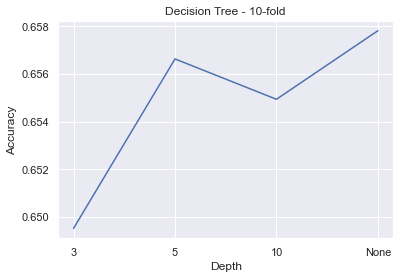

In [26]:
#Decision tree
kf = KFold(n_splits=10)
max_depth = [3,5,10,None]
performance_dict = {}
for max_d in max_depth:
    acc = []
    for train_index,val_index in kf.split(X_train):
        clf = DecisionTreeClassifier(max_depth = max_d, random_state=0, criterion='gini')
        X_Tr = X_train.iloc[train_index,:]
        Y_Tr = Y_train.iloc[train_index,:]
        X_V = X_train.iloc[val_index,:]
        Y_V = Y_train.iloc[val_index,:]
        clf = clf.fit(X_Tr, Y_Tr)
        Y_P = clf.predict(X_V)
        acc.append(metrics.accuracy_score(Y_V, Y_P))
    performance_dict[max_d] = np.mean(acc)
accuracies = list(performance_dict.values())
plt.title("Decision Tree - 10-fold")
plt.plot([1,2,3,4], accuracies)
plt.xticks([1,2,3,4],['3','5','10','None'])
plt.xlabel('Depth')
plt.ylabel('Accuracy')
#tree.plot_tree(clf)

### We get maximum accuracy with depth set at 'None'. Meaning, we are growing the tree all the way until we do not have any class ambiguitites in the leaf nodes.

In [31]:
clf = DecisionTreeClassifier(max_depth = None, random_state=0, criterion='gini')
clf = clf.fit(X_train,Y_train)
Y_P = clf.predict(X_test)
DT_Test_Acc = metrics.accuracy_score(Y_test, Y_P)
print("Decision Tree Test Accuracy at depth of None is...", DT_Test_Acc)

Decision Tree Test Accuracy at depth of None is... 0.6581892166836215


## Explaining the Decision Tree Plot
### For the sake of readability, we'll analyse the tree of depth 3 since tree of depth set at 'None' tends to be unreadable due to its huge size. More over, the test accuracy for depth = 3 is comparable to depth = None.

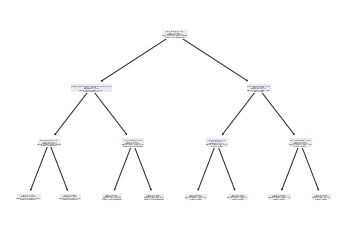

In [32]:
clf = DecisionTreeClassifier(max_depth = 3, random_state=0, criterion='gini')
clf = clf.fit(X_train,Y_train)
tree.plot_tree(clf,feature_names= feature_cols,class_names=class_nms)
text_representation = tree.export_text(clf, feature_names= feature_cols)
with open("Covid_DTree.txt",'w', encoding = 'utf-8') as f:
   f.write(text_representation)
#print(text_representation)

### 1) Examining the tree plot, we can notice that the first feature that is chosen for split is 'Age_Group'. This is inline with the inference we made by analysing the histogram of Age_Group feature in the [Feature Selection Process] of out pipeline. This is also inline with the evidence declared by global medical community that Covid-19 is more severe to older people. 'Age_Group' is one of the most important features that decide the outcome. Rightfully, the decision tree model was able to realise that splitting on 'Age_Group' gives the most amount of information gain. This fact has been captured by the algorithm. The split value of 6.5 can also be justified by looking at how splitting at this value gives increased information on Fatality as such.
### 2) Second set of splits are based on 'Case_Aq_Missing_Information' and 'Outbreak_Related'. This is also inline with the inference we had made in feature analysis process. From the histogram analysis, we can see how 'Missing_Information' can help clarify the separation between 'Resolved' and 'Not Resolved' outcomes. Rightfully, the split on Age_Group in the first step has cleared some ambiguity on 'Fatality' from the rest but not between 'Resolved' and 'Not Resolved'. 
### 3)A successive split on 'Missing_Information' which contains this information can help clear up that ambiguity. Similarly, we had inferred from the 'Outbreak_Related' histogram that, this feature gives class separation on 'Fatality' from the rest. Rightfully so, decision tree has chosen this feature to resolve ambiguity on 'Fatality' outcome further by choosing to split using this feature.
### 4) Successive splits are based on 'Age_Group' and 'City'. We can see how age group has been extensively used to decide on the outcome. This supports the scientific evidence that covid-19 is more dangerous to older population. This also supports the importance of this information.
### 5) It is interesting to realise how we can relate with the way decision tree builds its model to predict. It seems to follow an intuitive way that is easy for human comprehension and interpretation.
### 6) With regards to the explanation the tree provides on data, it essentially captures which features are more important and relevant to decide the outcome. This is also evident from the discussions mentioned in points 1 to 5 above.

## Random Forest

Text(30.5, 0.5, 'Depth')

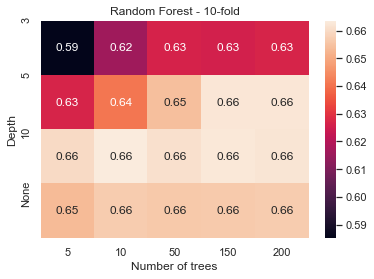

In [143]:
#Random Forest
kf = KFold(n_splits=10)
n_trees = [5,10,50,150,200]
max_depth = [3,5,10,None]
perf_n_tree = pd.DataFrame()
perf_depth = []
for n_tree in n_trees:
    perf_depth=[]
    for max_d in max_depth:
        acc = []
        for train_index,val_index in kf.split(X_train):
            clf = RandomForestClassifier(max_depth = max_d,n_estimators = n_tree, random_state=0)
            X_Tr = X_train.iloc[train_index,:]
            Y_Tr = Y_train.iloc[train_index,:]
            X_V = X_train.iloc[val_index,:]
            Y_V = Y_train.iloc[val_index,:]
            clf = clf.fit(X_Tr, Y_Tr)
            Y_P = clf.predict(X_V)
            acc.append(metrics.accuracy_score(Y_V, Y_P))
        perf_depth.append(np.mean(acc))
    #perf_n_tree[n_tree]=copy.deepcopy(perf_depth)
    perf_n_tree[str(n_tree)]=perf_depth
accuracies = list(performance_dict.values())
plt.title("Random Forest - 10-fold")
hm = sns.heatmap(perf_n_tree, annot=True)
plt.yticks([0,1,2,3],['3','5','10','None'])
plt.xlabel('Number of trees')
plt.ylabel('Depth')

## Evaluating hyperparameters for Random Forest
### From the heatmap plot above, we can see that we attain best performance at a range of values the hyperparameters of Depth and Number of Trees. Among this, the best value would be Depth = 10 & Number of Trees = 10 considering the positive impact it would have on computation performance and inference speed. Higher these two parameters are, more is the performance overhead interms of storage and computation.

In [33]:
clf = RandomForestClassifier(max_depth = 10, n_estimators=10, random_state=0)
clf = clf.fit(X_train,Y_train)
Y_P = clf.predict(X_test)
RF_Test_Acc = metrics.accuracy_score(Y_test, Y_P)
print("Random Forest Test Accuracy at depth of 5 and Max 200 no of trees is...", RF_Test_Acc)

Random Forest Test Accuracy at depth of 5 and Max 200 no of trees is... 0.6720922346558156


## Gradient Boosting

Text(0, 0.5, 'Accuracy')

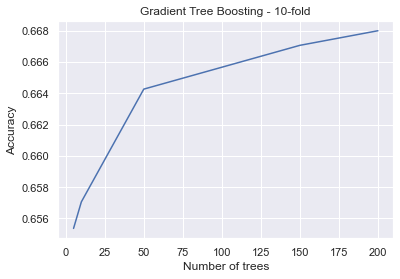

In [145]:
#Gradient Boosting Classifier
kf = KFold(n_splits=10)
n_trees = [5,10,50,150,200]
perf_n_tree = []
for n_tree in n_trees:
    acc = []
    for train_index,val_index in kf.split(X_train):
        clf = GradientBoostingClassifier(n_estimators = n_tree)
        X_Tr = X_train.iloc[train_index,:]
        Y_Tr = Y_train.iloc[train_index,:]
        X_V = X_train.iloc[val_index,:]
        Y_V = Y_train.iloc[val_index,:]
        clf = clf.fit(X_Tr, Y_Tr)
        Y_P = clf.predict(X_V)
        acc.append(metrics.accuracy_score(Y_V, Y_P))
    perf_n_tree.append(np.mean(acc))
    #perf_n_tree[n_tree]=copy.deepcopy(perf_depth)
plt.title("Gradient Tree Boosting - 10-fold")
plt.plot(n_trees, perf_n_tree)
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')

## Performance and hyperparameter evaluation
### Performance peaks at 200 number of trees and hence we will choose that for the number of trees hyperparameter value.

In [34]:
clf = GradientBoostingClassifier(n_estimators=200)
clf = clf.fit(X_train,Y_train)
Y_P = clf.predict(X_test)
GB_Test_Acc = metrics.accuracy_score(Y_test, Y_P)
print("Gradient Boosting Test Accuracy at  Max 200 no of trees is...", GB_Test_Acc)

Gradient Boosting Test Accuracy at  Max 200 no of trees is... 0.676500508646999


## Prep test data for kaggle

In [131]:
df_test = pd.read_csv('covid_tests.csv')
len(df_test)

3713

In [133]:
df_test = step1(df_test, train = False)
df_test = step2(df_test)
df_test = step3(df_test)

In [418]:
df_test = pd.read_csv('covid_tests.csv')
df_test['Age_Group'] = df_test['Age_Group'].replace('<20',1).replace('20s',2).replace('30s',3).replace('40s',4).replace('50s',5).replace('60s',6).replace('70s',7).replace('80s',8).replace('90s',9)
#df_test['Outcome1']=df_test['Outcome1'].replace('Resolved',1).replace('Fatal',-1).replace('Not Resolved',0)
df_test['Outbreak_Related'] = df_test['Outbreak_Related'].replace('Yes',1).replace(np.nan,0)
df_test['Client_Gender'] = df_test['Client_Gender'].replace('UNSPECIFIED',np.nan)
df_test['Case_AcquisitionInfo']=df_test['Case_AcquisitionInfo'].replace('TRAVEL','OTHERWISE').replace('NO KNOWN EPI LINK','OTHERWISE').replace('UNSPECIFIED EPI LINK','OTHERWISE').replace("CC","OTHERWISE")

countries_chosen = ["Toronto", "Mississauga", "Newmarket", "Ottawa", "Whitby", "Windsor", "Thorold", "Hamilton", "Oakville", "Waterloo", "London", "Barrie", "Guelph", "Cornwall", "St. Thomas", "Thunder Bay", "Brockville", "Sudbury", "Chatham", "Timmins"]
#countries_chosen = ["Toronto", "Ottawa", "Whitby", "Windsor", "Thorold", "Hamilton", "London", "Barrie", "Guelph", "St. Thomas", "Thunder Bay", "Brockville", "Sudbury", "Chatham", "Timmins"]
for country in list(df_test["Reporting_PHU_City"].unique()):
    if country not in countries_chosen:
        df_test['Reporting_PHU_City'] = df_test['Reporting_PHU_City'].replace(country,"OTHERWISE")

gender_dummy = pd.get_dummies(df_test.Client_Gender,prefix='Gender')
Case_Aq_dummy = pd.get_dummies(df_test.Case_AcquisitionInfo,prefix='Case_Aq')
City_dummy = pd.get_dummies(df_test.Reporting_PHU_City,prefix='City')
drop_clm = ['Reporting_PHU_City','Client_Gender','Case_AcquisitionInfo','Reporting_PHU_Latitude','Reporting_PHU_Longitude']
df_test = df_test.drop(columns=drop_clm)
df_test = pd.concat([df_test,City_dummy,Case_Aq_dummy],axis=1)
len(df_test)

3713

In [134]:
#clf = RandomForestClassifier(max_depth = 10, n_estimators=10, random_state=0)
#clf = clf.fit(X_train,Y_train)
Y_P = clf.predict(df_test)

In [135]:
pred = pd.DataFrame()
pred["id"] = range(len(Y_P))
pred["Outcome1"] = list(Y_P)
pred['Outcome1']=pred['Outcome1'].replace(1,"Resolved").replace(-1,"Fatal").replace(0,"Not Resolved")
#df['Outcome1']=df['Outcome1'].replace('Resolved',1).replace('Fatal',-1).replace('Not Resolved',0)
pred.to_csv("pred.csv",index=False)

# Exploring the model without preprocessing

In [3]:
df = pd.read_csv('covid_train.csv')
df['Age_Group'] = df['Age_Group'].replace('<20',1).replace('20s',2).replace('30s',3).replace('40s',4).replace('50s',5).replace('60s',6).replace('70s',7).replace('80s',8).replace('90s',9)
df['Outcome1']=df['Outcome1'].replace('Resolved',1).replace('Fatal',-1).replace('Not Resolved',0)
df['Outbreak_Related'] = df['Outbreak_Related'].replace('Yes',1).replace(np.nan,0)
#df['Client_Gender'] = df['Client_Gender'].replace('UNSPECIFIED',np.nan)
#df['Case_AcquisitionInfo']=df['Case_AcquisitionInfo'].replace('NO KNOWN EPI LINK','OTHERWISE').replace('UNSPECIFIED EPI LINK','OTHERWISE')
df = df.dropna()
gender_dummy = pd.get_dummies(df.Client_Gender,prefix='Gender')
Case_Aq_dummy = pd.get_dummies(df.Case_AcquisitionInfo,prefix='Case_Aq')
City_dummy = pd.get_dummies(df.Reporting_PHU_City,prefix='City')
drop_clm = ['Client_Gender','Case_AcquisitionInfo','Reporting_PHU_City']
df = df.drop(columns=drop_clm)
df = pd.concat([df,gender_dummy,Case_Aq_dummy, City_dummy],axis=1)
feature_cols = list(df.columns)
target_col = 'Outcome1'
feature_cols.remove(target_col)
df_feat = df[feature_cols]
df_target = df.drop(columns = feature_cols)
class_nms = ['Fatal','Not Resolved','Resolved']

In [4]:
X_train,X_test,Y_train,Y_test = train_test_split(df_feat,df_target, test_size = 0.2, random_state= 225)

Text(0, 0.5, 'Accuracy')

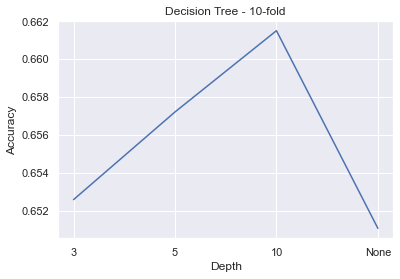

In [5]:
#Decision tree
kf = KFold(n_splits=10)
max_depth = [3,5,10,None]
performance_dict = {}
for max_d in max_depth:
    acc = []
    for train_index,val_index in kf.split(X_train):
        clf = DecisionTreeClassifier(max_depth = max_d, random_state=0, criterion='gini')
        X_Tr = X_train.iloc[train_index,:]
        Y_Tr = Y_train.iloc[train_index,:]
        X_V = X_train.iloc[val_index,:]
        Y_V = Y_train.iloc[val_index,:]
        clf = clf.fit(X_Tr, Y_Tr)
        Y_P = clf.predict(X_V)
        acc.append(metrics.accuracy_score(Y_V, Y_P))
    performance_dict[max_d] = np.mean(acc)
accuracies = list(performance_dict.values())
plt.title("Decision Tree - 10-fold")
plt.plot([1,2,3,4], accuracies)
plt.xticks([1,2,3,4],['3','5','10','None'])
plt.xlabel('Depth')
plt.ylabel('Accuracy')
#tree.plot_tree(clf)

In [7]:
clf = DecisionTreeClassifier(max_depth = 10, random_state=0, criterion='gini')
clf = clf.fit(X_train,Y_train)
Y_P = clf.predict(X_test)
DT_Test_Acc = metrics.accuracy_score(Y_test, Y_P)
print("Decision Tree Test Accuracy at depth of 10 is...", DT_Test_Acc)

Decision Tree Test Accuracy at depth of 10 is... 0.6581340518693163


Text(30.5, 0.5, 'Depth')

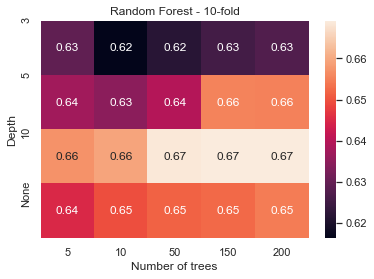

In [8]:
#Random Forest
kf = KFold(n_splits=10)
n_trees = [5,10,50,150,200]
max_depth = [3,5,10,None]
perf_n_tree = pd.DataFrame()
perf_depth = []
for n_tree in n_trees:
    perf_depth=[]
    for max_d in max_depth:
        acc = []
        for train_index,val_index in kf.split(X_train):
            clf = RandomForestClassifier(max_depth = max_d,n_estimators = n_tree, random_state=0)
            X_Tr = X_train.iloc[train_index,:]
            Y_Tr = Y_train.iloc[train_index,:]
            X_V = X_train.iloc[val_index,:]
            Y_V = Y_train.iloc[val_index,:]
            clf = clf.fit(X_Tr, Y_Tr)
            Y_P = clf.predict(X_V)
            acc.append(metrics.accuracy_score(Y_V, Y_P))
        perf_depth.append(np.mean(acc))
    #perf_n_tree[n_tree]=copy.deepcopy(perf_depth)
    perf_n_tree[str(n_tree)]=perf_depth
accuracies = list(performance_dict.values())
plt.title("Random Forest - 10-fold")
hm = sns.heatmap(perf_n_tree, annot=True)
plt.yticks([0,1,2,3],['3','5','10','None'])
plt.xlabel('Number of trees')
plt.ylabel('Depth')

In [9]:
clf = RandomForestClassifier(max_depth = 10, n_estimators=50, random_state=0)
clf = clf.fit(X_train,Y_train)
Y_P = clf.predict(X_test)
RF_Test_Acc = metrics.accuracy_score(Y_test, Y_P)
print("Random Forest Test Accuracy at depth of 10 and Max 50 no of trees is...", RF_Test_Acc)

Random Forest Test Accuracy at depth of 10 and Max 50 no of trees is... 0.6702593465813406


Text(0, 0.5, 'Accuracy')

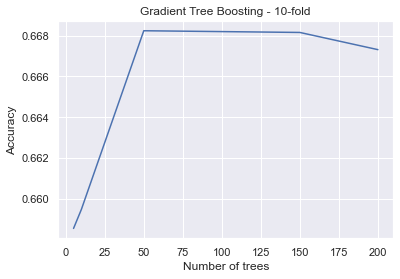

In [10]:
#Gradient Boosting Classifier
kf = KFold(n_splits=10)
n_trees = [5,10,50,150,200]
perf_n_tree = []
for n_tree in n_trees:
    acc = []
    for train_index,val_index in kf.split(X_train):
        clf = GradientBoostingClassifier(n_estimators = n_tree)
        X_Tr = X_train.iloc[train_index,:]
        Y_Tr = Y_train.iloc[train_index,:]
        X_V = X_train.iloc[val_index,:]
        Y_V = Y_train.iloc[val_index,:]
        clf = clf.fit(X_Tr, Y_Tr)
        Y_P = clf.predict(X_V)
        acc.append(metrics.accuracy_score(Y_V, Y_P))
    perf_n_tree.append(np.mean(acc))
    #perf_n_tree[n_tree]=copy.deepcopy(perf_depth)
plt.title("Gradient Tree Boosting - 10-fold")
plt.plot(n_trees, perf_n_tree)
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')

In [11]:
clf = GradientBoostingClassifier(n_estimators=50)
clf = clf.fit(X_train,Y_train)
Y_P = clf.predict(X_test)
GB_Test_Acc = metrics.accuracy_score(Y_test, Y_P)
print("Gradient Boosting Test Accuracy at  Max 150 no of trees is...", GB_Test_Acc)

Gradient Boosting Test Accuracy at  Max 150 no of trees is... 0.6705961603233412


### Here we can see that there isn't much difference in performance between the model with good preprocessing and the model without preprocessing. However, preprocessing is an important step. Identifying and weeding out irrelevant and redundant features helps the model to capture the underlying  relationship between input and output more effectively. This also helps the model become more interpretable as having redundant and uninformative features will only clutter the plot and make interpretation harder. Interpretability is one of the strong points of decision trees and blindly applying decision trees without prior preprocessing impacts negatively on interpretability.